In [1]:
import os
import glob
import sys

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
base_path = '../experiments/'
model = 'resnet18'

MODELS = {
    'resnet18': 'resnet18',
    'efficientnet': 'efficientnet',
    'densenet': 'densenet'
}

METHODS = {
    "ig": "ig",
    "saliency": "saliency",
    "gradcam": "gradcam",
    "gradshap": "gradshap",
    "gbp": "gbp",
}

SPLIT_OPTIONS = ["100%", "80%", "60%", "40%", "20%"]

DATASETS = {
    "edible-plants": "edible-plants",
    "food101": "food101",
    "marvel": "marvel",
    "plant-data": "plant-data",
    "stanford-dogs": "stanford-dogs",
}
AUG_TYPES = [
    'rotation',
    'filters'
]
KEYS = {
    'rotation': [
        '# 0-ssim',
        '0-score',
        ['-30-ssim',
        '-30-score'],
        ['-15-ssim',
        '-15-score'],
        ['15-ssim',
        '15-score'],
        ['30-ssim',
        '30-score']
    ],
    'filters': [
        "# none-ssim",
        "none-score",
        ["fx_freaky_details 2,10,1,11,0,32,0-ssim",
        "fx_freaky_details 2,10,1,11,0,32,0-score"],
        ["normalize_local 8,10-ssim",
        "normalize_local 8,10-score"],
        ["fx_boost_chroma 90,0,0-ssim",
        "fx_boost_chroma 90,0,0-score"],
        ["fx_mighty_details 25,1,25,1,11,0-ssim",
        "fx_mighty_details 25,1,25,1,11,0-score"],
        ["sharpen 300-ssim",
        "sharpen 300-score"]
    ]
}

LABEL_MAP = {
    '-30-ssim-ig': 'Integrated Gradinets: -30° rotation',
    '-30-ssim-saliency': 'Saliency: -30° rotation',
    '-30-ssim-gradcam': 'Guided GradCAM: -30° rotation',
    '-30-ssim-gradshap': 'Gradient SHAP: -30° rotation',
    '-30-ssim-gbp': 'Guided Backpropagation: -30° rotation',
    '-15-ssim-ig': 'Integrated Gradinets: -15° rotation',
    '-15-ssim-saliency': 'Saliency: -15° rotation',
    '-15-ssim-gradcam': 'Guided GradCAM: -15° rotation',
    '-15-ssim-gradshap': 'Gradient SHAP: -15° rotation',
    '-15-ssim-gbp': 'Guided Backpropagation: -15° rotation',
    '15-ssim-ig': 'Integrated Gradinets: 15° rotation',
    '15-ssim-saliency': 'Saliency: 15° rotation',
    '15-ssim-gradcam': 'Guided GradCAM: 15° rotation',
    '15-ssim-gradshap': 'Gradient SHAP: 15° rotation',
    '15-ssim-gbp': 'Guided Backpropagation: 15° rotation',
    '30-ssim-ig': 'Integrated Gradinets: 30° rotation',
    '30-ssim-saliency': 'Saliency: 30° rotation',
    '30-ssim-gradcam': 'Guided GradCAM: 30° rotation',
    '30-ssim-gradshap': 'Gradient SHAP: 30° rotation',
    '30-ssim-gbp': 'Guided Backpropagation: 30° rotation',
    'ig': 'Integrated Gradinets',
    'saliency': 'Saliency',
    'gradcam': 'Guided GradCAM',
    'gradshap': 'Gradient SHAP',
    'gbp': 'Guided Backpropagation',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-ig': 'Integrated Gradinets: Freaky Details',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-saliency': 'Saliency: Freaky Details',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-gradcam': 'Guided GradCAM: Freaky Details',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-gradshap': 'Gradient SHAP: Freaky Details',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-gbp': 'Guided Backpropagation: Freaky Details',
    'normalize_local 8,10-ssim-ig': 'Integrated Gradinets: Local Normalization',
    'normalize_local 8,10-ssim-saliency': 'Saliency: Local Normalization',
    'normalize_local 8,10-ssim-gradcam': 'Guided GradCAM: Local Normalization',
    'normalize_local 8,10-ssim-gradshap': 'Gradient SHAP: Local Normalization',
    'normalize_local 8,10-ssim-gbp': 'Guided Backpropagation: Local Normalization',
    'fx_boost_chroma 90,0,0-ssim-ig': 'Integrated Gradinets: Chroma Boost',
    'fx_boost_chroma 90,0,0-ssim-saliency': 'Saliency: Chroma Boost',
    'fx_boost_chroma 90,0,0-ssim-gradcam': 'Guided GradCAM: Chroma Boost',
    'fx_boost_chroma 90,0,0-ssim-gradshap': 'Gradient SHAP: Chroma Boost',
    'fx_boost_chroma 90,0,0-ssim-gbp': 'Guided Backpropagation: Chroma Boost',
    'fx_mighty_details 25,1,25,1,11,0-ssim-ig': 'Integrated Gradinets: Mighty Details',
    'fx_mighty_details 25,1,25,1,11,0-ssim-saliency': 'Saliency: Mighty Details',
    'fx_mighty_details 25,1,25,1,11,0-ssim-gradcam': 'Guided GradCAM: Mighty Details',
    'fx_mighty_details 25,1,25,1,11,0-ssim-gradshap': 'Gradient SHAP: Mighty Details',
    'fx_mighty_details 25,1,25,1,11,0-ssim-gbp': 'Guided Backpropagation: Mighty Details',
    'sharpen 300-ssim-ig': 'Integrated Gradinets: Sharpen',
    'sharpen 300-ssim-saliency': 'Saliency: Sharpen',
    'sharpen 300-ssim-gradcam': 'Guided GradCAM: Sharpen',
    'sharpen 300-ssim-gradshap': 'Gradient SHAP: Sharpen',
    'sharpen 300-ssim-gbp': 'Guided Backpropagation: Sharpen',
}

threshold = 0.05


fig_size = (30,16)
title_font=32
label_font=28
marker_size=18

plt.rcParams.update({'font.size': 22})

In [3]:

SSIM = {
    'rotation': {},
    'filters': {},
}
SSIM_METHODS = {
    
}
RESULTS = {
    'rotation': {},
    'filters': {},
}

In [4]:
## Extract data from csv files

In [5]:
for model in MODELS.keys():
    for dataset in DATASETS.keys():
        for data_split in SPLIT_OPTIONS:
            for aug_type in AUG_TYPES:
                for method in METHODS.keys():
                    if not method in SSIM[aug_type]:
                        SSIM[aug_type][method] = pd.DataFrame()
                    res_path = os.path.join(base_path, aug_type, dataset, f"{model}-{data_split}", method, f"{model}-{dataset}-{method}-ssim-with-range.csv")
                    method_df = pd.read_csv(res_path, delimiter=';')

                    SSIM[aug_type][method] = SSIM[aug_type][method].append(method_df, ignore_index=True)
            
            
for model in MODELS.keys():
    for dataset in DATASETS.keys():
        for data_split in SPLIT_OPTIONS:
            for aug_type in AUG_TYPES:
                for method in METHODS.keys():
                    if not method in SSIM_METHODS:
                        SSIM_METHODS[method] = pd.DataFrame()
                    res_path = os.path.join(base_path, aug_type, dataset, f"{model}-{data_split}", method, f"{model}-{dataset}-{method}-ssim-with-range.csv")
                    method_df = pd.read_csv(res_path, delimiter=';')

                    SSIM_METHODS[method] = SSIM_METHODS[method].append(method_df, ignore_index=True)
        


In [6]:
print(len(SSIM['rotation']['ig']))

1455


In [7]:
print(len(SSIM_METHODS['ig']))

2910


In [8]:
### Drop values outside threshold

In [9]:
for aug_type in AUG_TYPES:
    for method in METHODS.keys():
        for aug_method in KEYS[aug_type][2:]:
            SSIM[aug_type][method][aug_method[0]] = SSIM[aug_type][method][aug_method[0]][(SSIM[aug_type][method][aug_method[1]] - SSIM[aug_type][method][KEYS[aug_type][1]]).abs() < threshold]
            
for method in METHODS.keys():
    for aug_method in KEYS[AUG_TYPES[0]][2:]:
        SSIM_METHODS[method][aug_method[0]] = SSIM_METHODS[method][aug_method[0]][(SSIM_METHODS[method][aug_method[1]] - SSIM_METHODS[method][KEYS[AUG_TYPES[0]][1]]).abs() < threshold]
    for aug_method in KEYS[AUG_TYPES[1]][2:]:
        SSIM_METHODS[method][aug_method[0]] = SSIM_METHODS[method][aug_method[0]][(SSIM_METHODS[method][aug_method[1]] - SSIM_METHODS[method][KEYS[AUG_TYPES[1]][1]]).abs() < threshold]

In [10]:
for aug_type in AUG_TYPES:
    for method in METHODS.keys():
        for aug_method in KEYS[aug_type][2:]:
            if not method in RESULTS[aug_type]:
                RESULTS[aug_type][method] = {}
                RESULTS[aug_type][method]['mean'] = SSIM[aug_type][method][
                    [
                        aug_arr[0] for aug_arr in KEYS[aug_type][2:]
                    ]
                ].stack().mean(skipna=True)
                RESULTS[aug_type][method]['std'] = SSIM[aug_type][method][
                    [
                        aug_arr[0] for aug_arr in KEYS[aug_type][2:]
                    ]
                ].stack().std(skipna=True)
                
            if not aug_method[0] in RESULTS[aug_type][method]:
                RESULTS[aug_type][method][aug_method[0]] = { 'mean': 0, 'std': 0 }
                
            RESULTS[aug_type][method][aug_method[0]]['mean'] = SSIM[aug_type][method][aug_method[0]].mean(skipna=True)
            RESULTS[aug_type][method][aug_method[0]]['std'] = SSIM[aug_type][method][aug_method[0]].std(skipna=True)
            
            
            
for method in METHODS.keys():
    if not method in RESULTS:
        RESULTS[method] = {}
        
    RESULTS[method]['mean'] = SSIM_METHODS[method][
        [
            aug_arr[0] for aug_arr in KEYS[AUG_TYPES[0]][2:] + KEYS[AUG_TYPES[1]][2:]
        ]
    ].stack().mean(skipna=True)
    RESULTS[method]['std'] = SSIM_METHODS[method][
        [
            aug_arr[0] for aug_arr in KEYS[AUG_TYPES[0]][2:] + KEYS[AUG_TYPES[1]][2:]
        ]
    ].stack().std(skipna=True)

In [11]:
all_means = []
all_stds = []
all_labels = []

<Figure size 2160x1872 with 0 Axes>

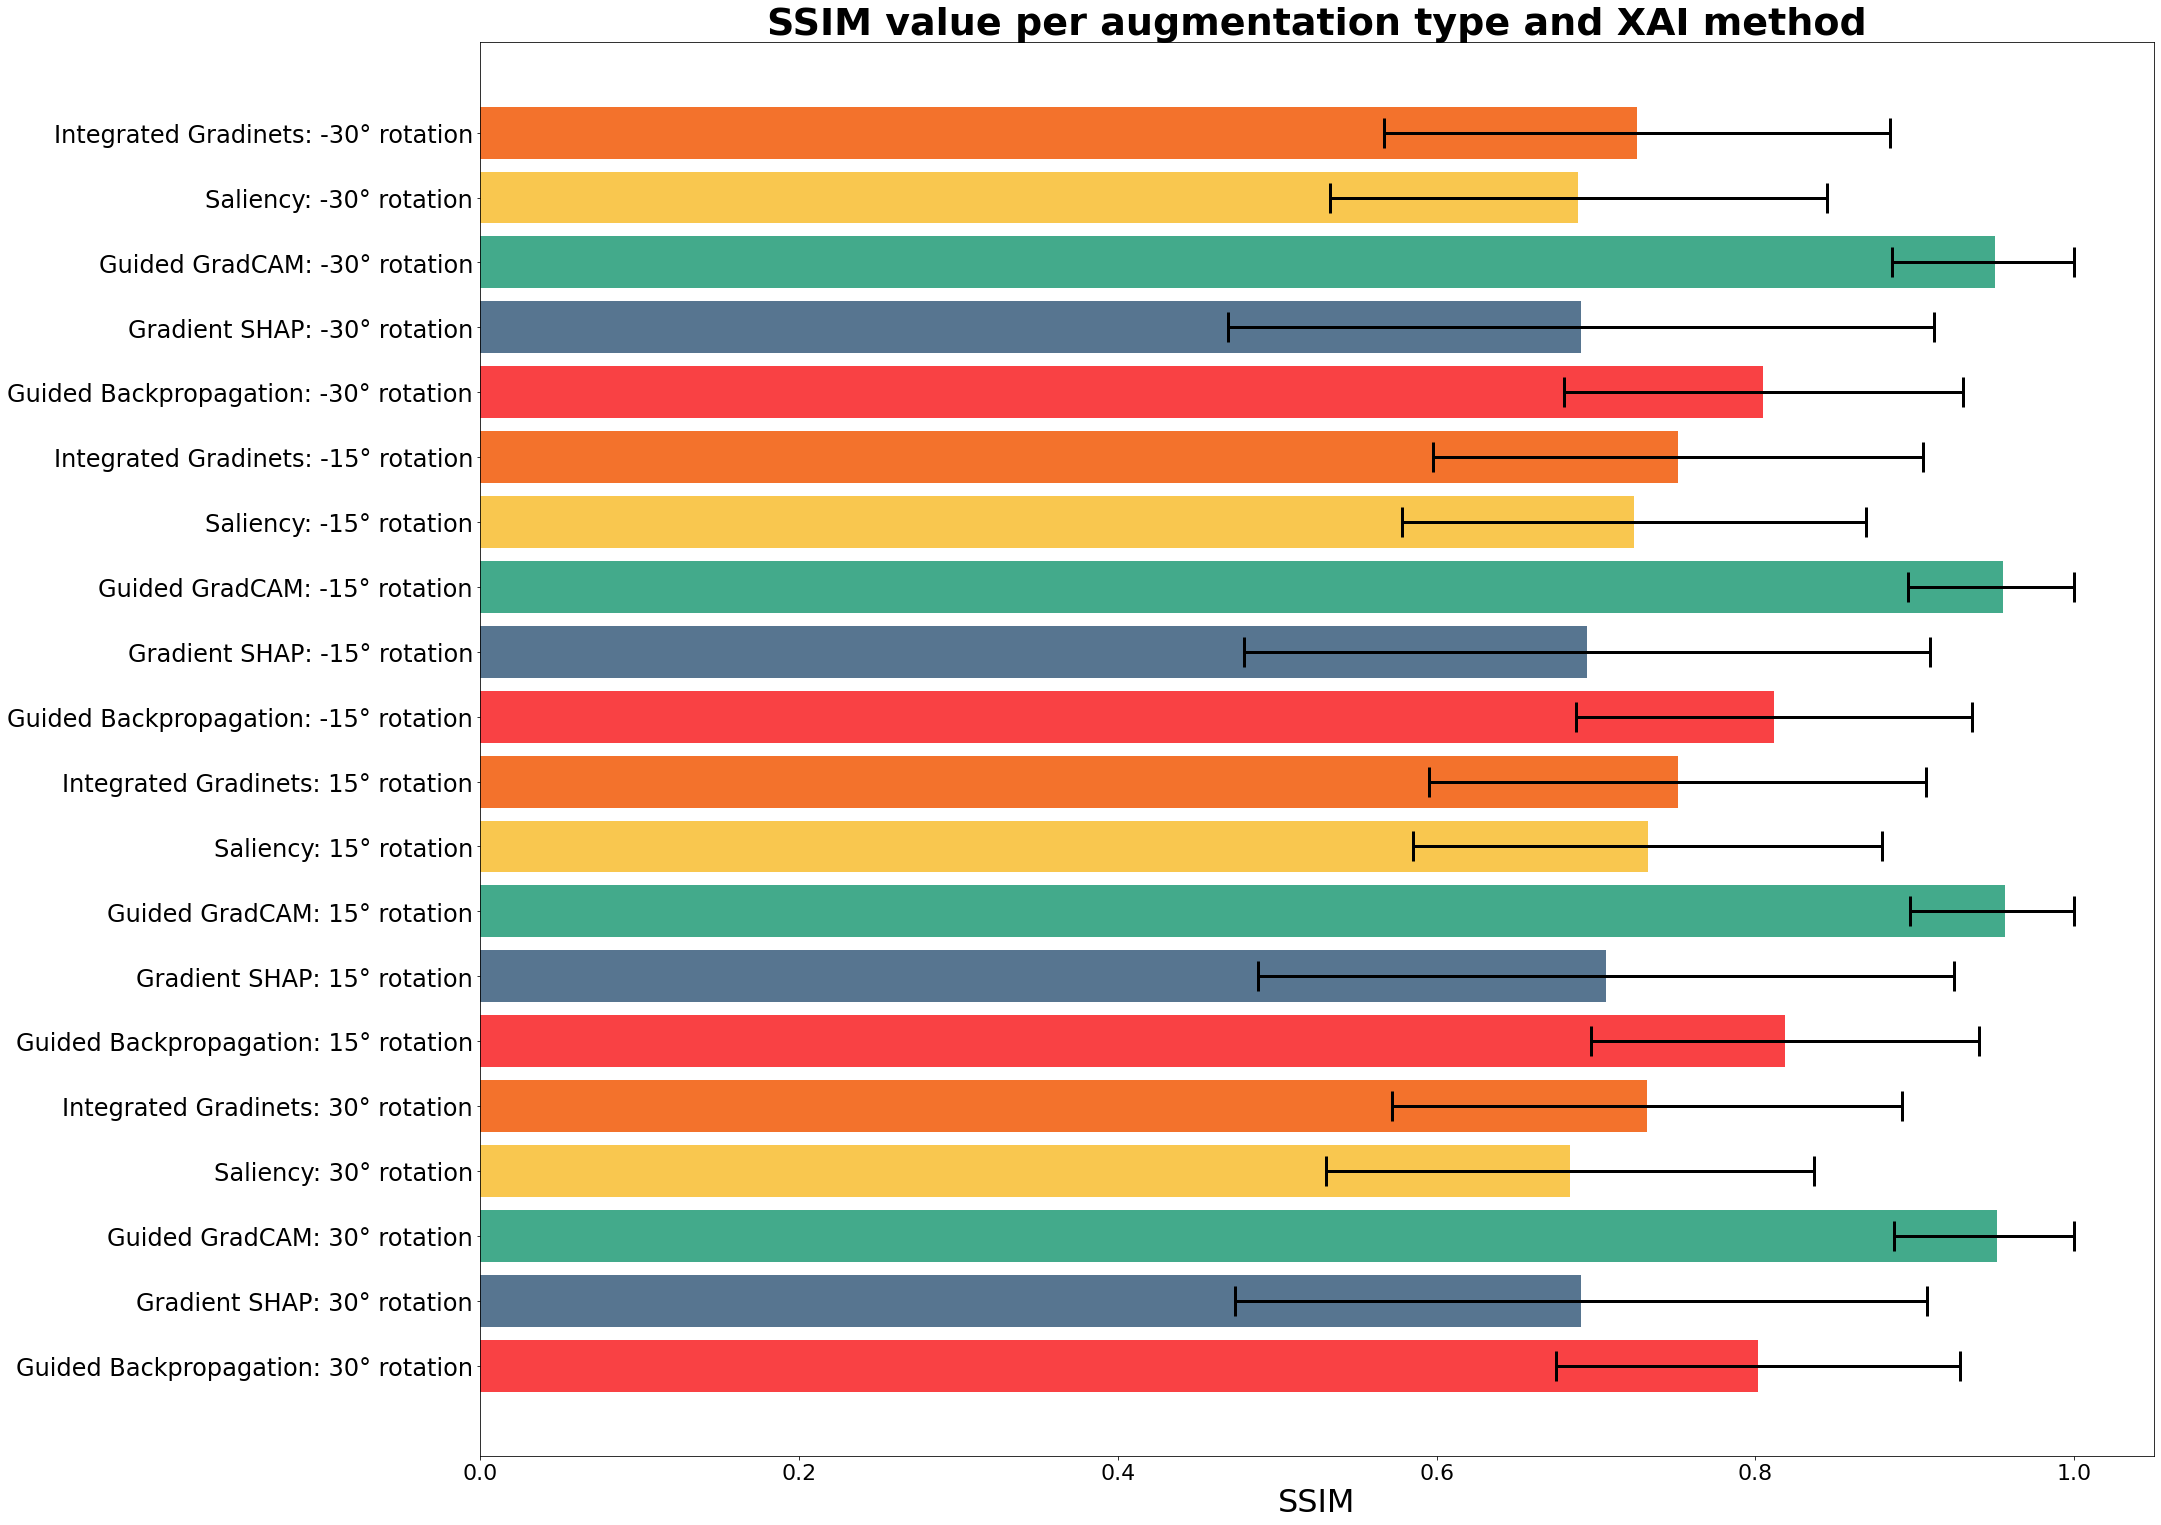

In [96]:
labels = []
means = []
stds = []

colors = [
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,26)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

aug_type = AUG_TYPES[0]
for aug_method in KEYS[aug_type][2:]:
    for method in METHODS.keys():
        means.append(RESULTS[aug_type][method][aug_method[0]]['mean'])
        stds.append([
            RESULTS[aug_type][method][aug_method[0]]['std'], 
            min(1.0 - RESULTS[aug_type][method][aug_method[0]]['mean'], RESULTS[aug_type][method][aug_method[0]]['std'])
        ])
        labels.append(LABEL_MAP[aug_method[0] + '-' + method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    capsize=15, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=24)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per augmentation type and XAI method', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/rotation-ssim.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/rotation-ssim.png', bbox_inches='tight')

all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + labels

<Figure size 2160x1152 with 0 Axes>

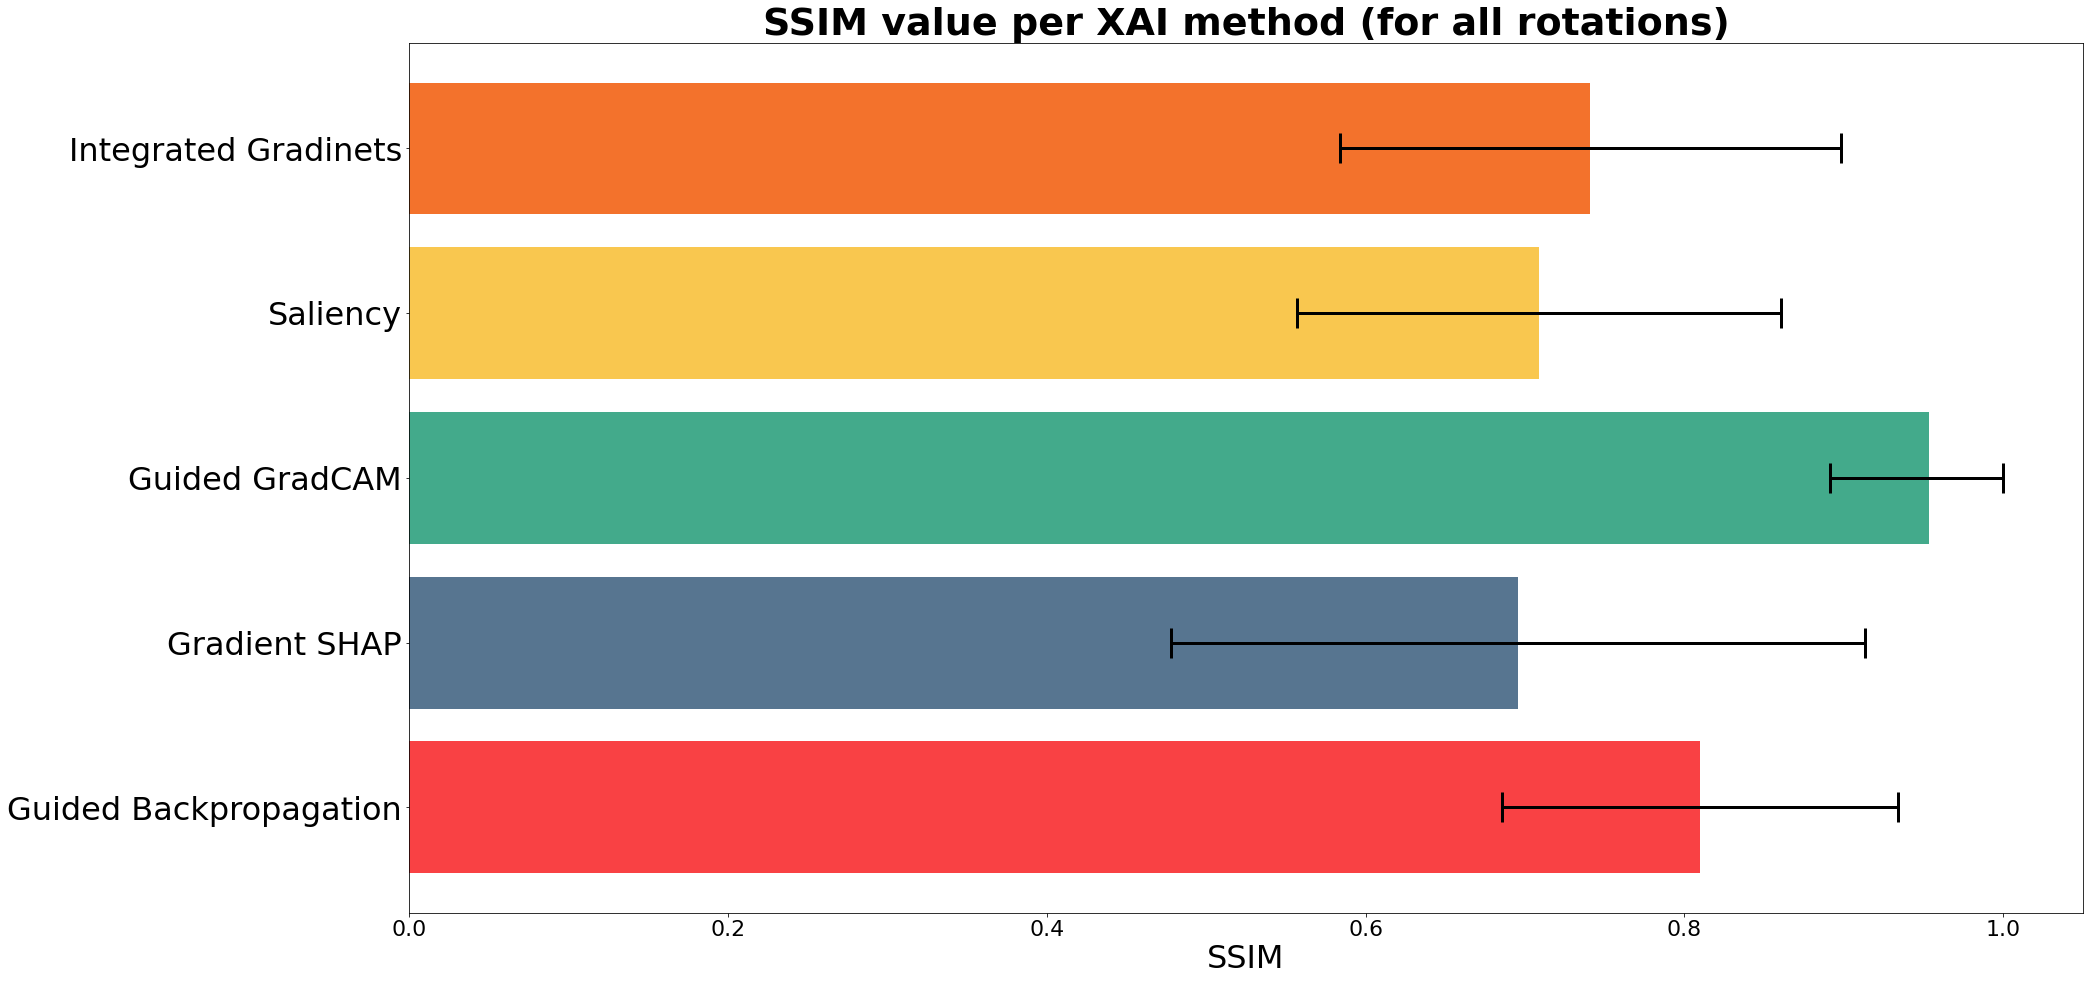

In [97]:
labels = []
means = []
stds = []

colors = [
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,16)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

aug_type = AUG_TYPES[0]
for method in METHODS.keys():
    means.append(RESULTS[aug_type][method]['mean'])
    stds.append([
        RESULTS[aug_type][method]['std'], 
        min(1.0 - RESULTS[aug_type][method]['mean'], RESULTS[aug_type][method]['std'])
    ])
    labels.append(LABEL_MAP[method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=32)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per XAI method (for all rotations)', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/rotation-all.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/rotation-all.png', bbox_inches='tight')
all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + [ '(rotations)' + label for label in labels ]

<Figure size 2160x1872 with 0 Axes>

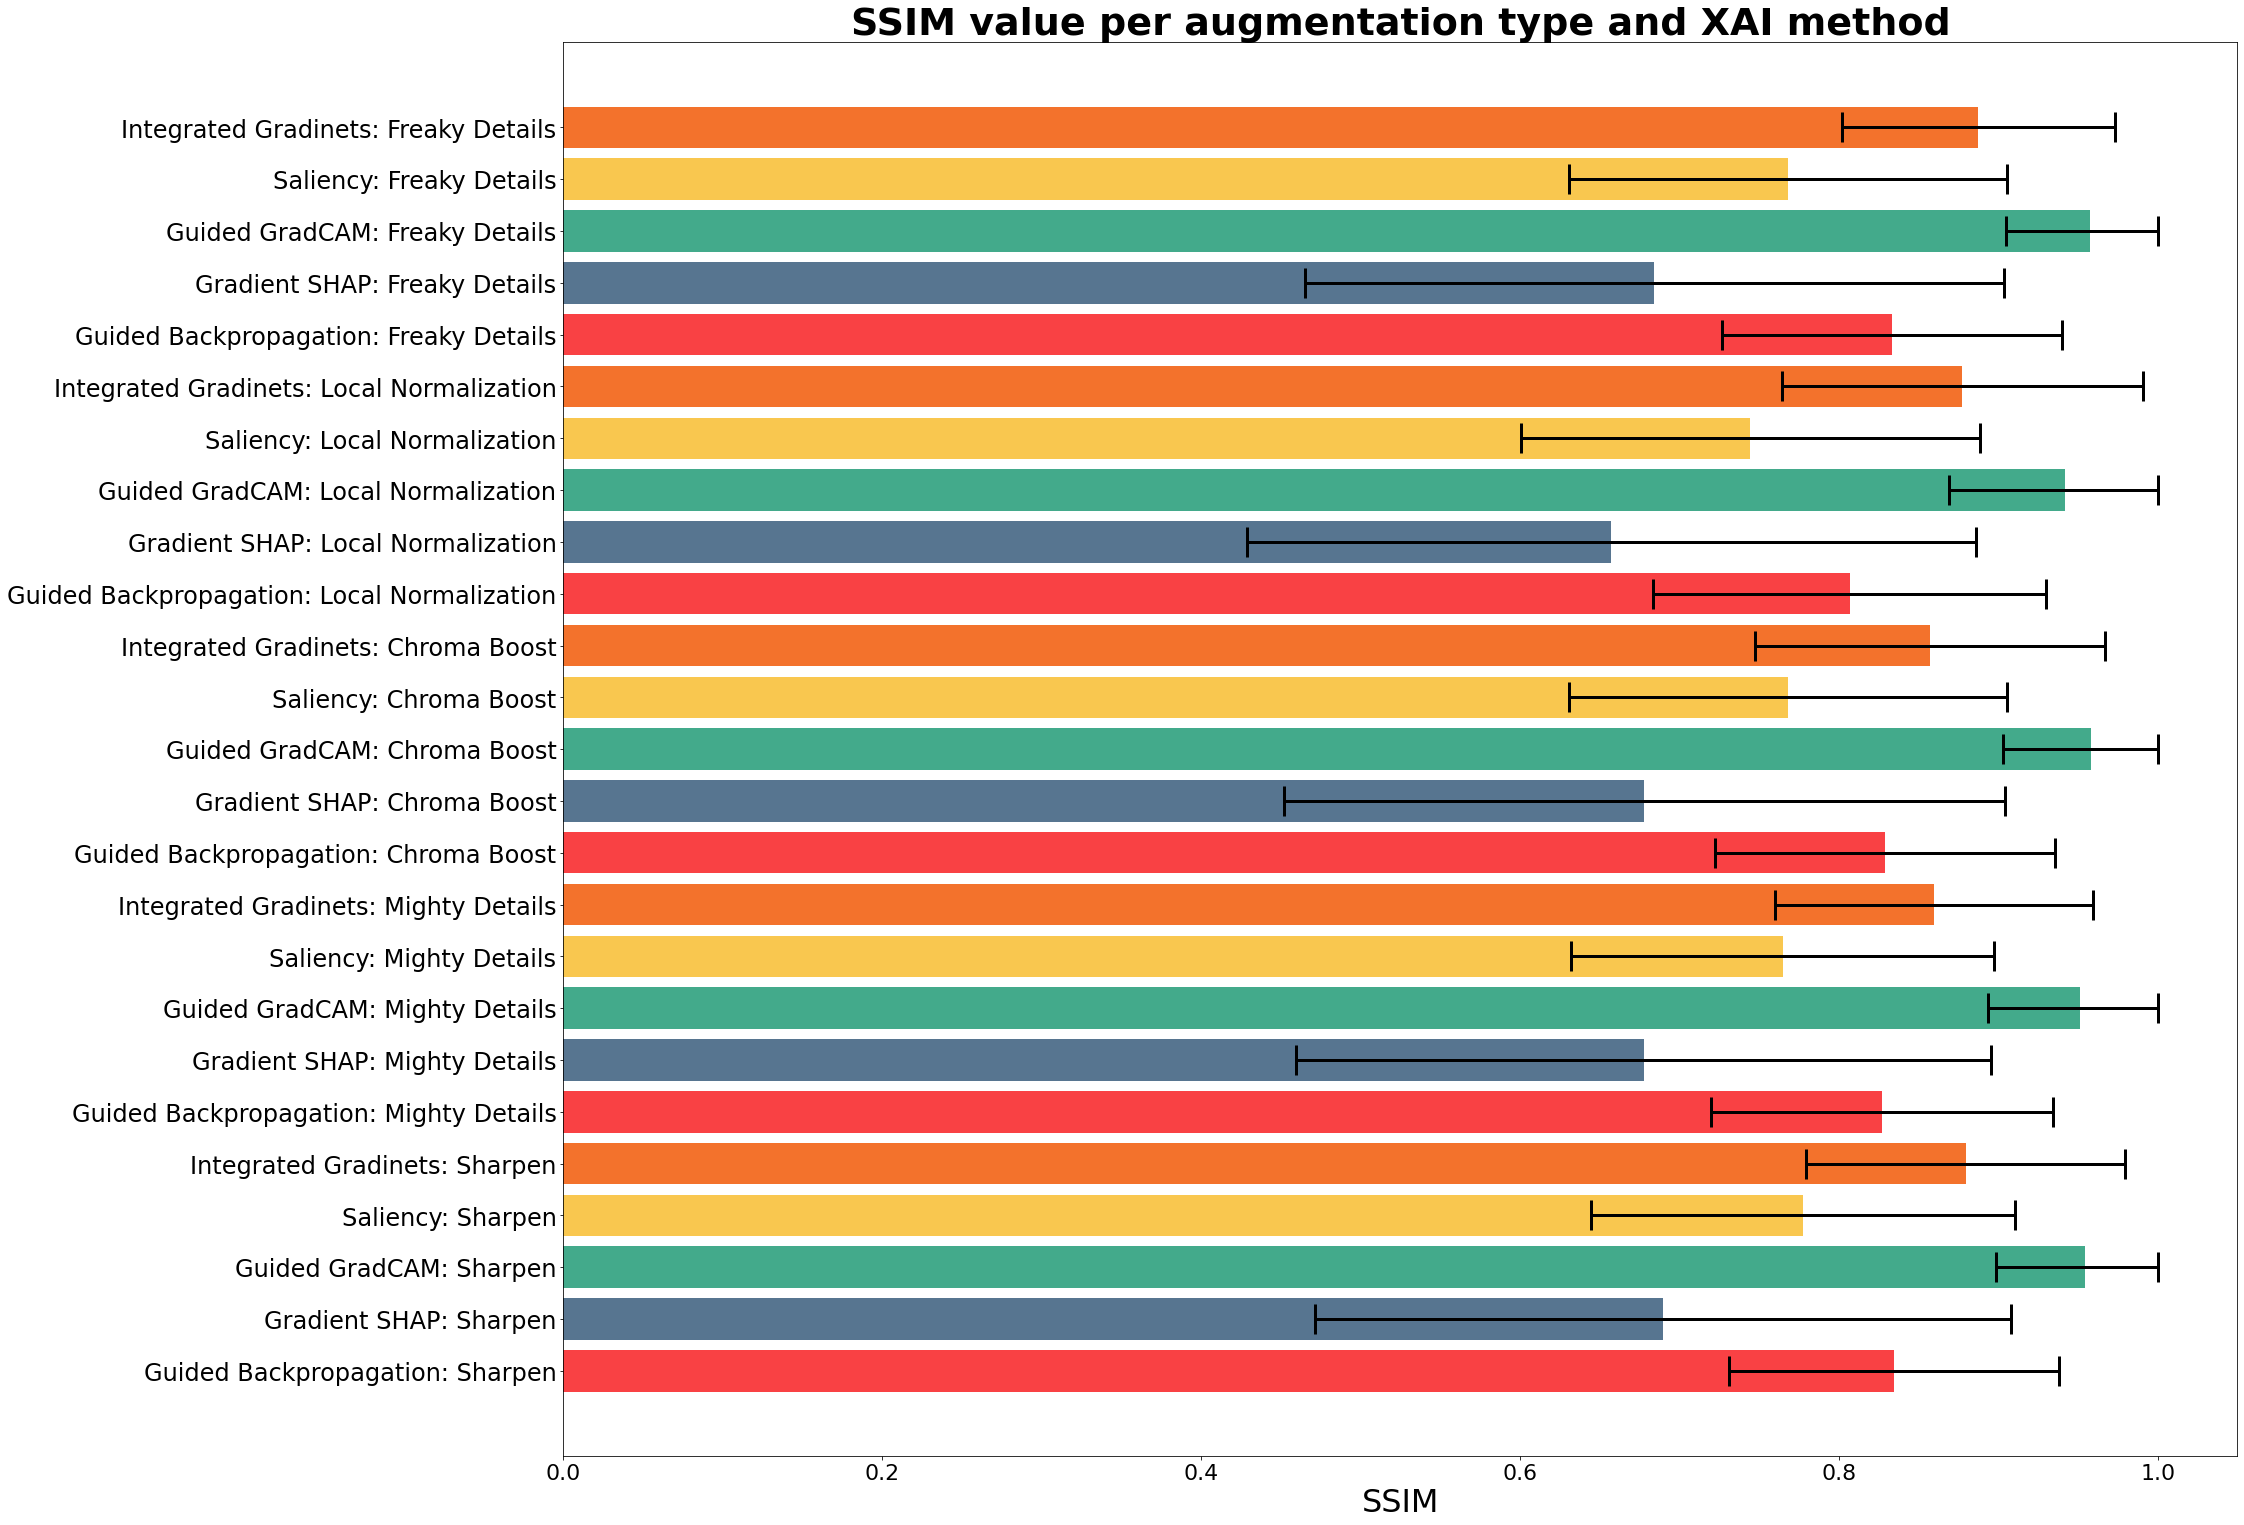

In [98]:
labels = []
means = []
stds = []

colors = [
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,26)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

aug_type = AUG_TYPES[1]
for aug_method in KEYS[aug_type][2:]:
    for method in METHODS.keys():
        means.append(RESULTS[aug_type][method][aug_method[0]]['mean'])
        stds.append([
            RESULTS[aug_type][method][aug_method[0]]['std'], 
            min(1.0 - RESULTS[aug_type][method][aug_method[0]]['mean'], RESULTS[aug_type][method][aug_method[0]]['std'])
        ])
        labels.append(LABEL_MAP[aug_method[0] + '-' + method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    capsize=15, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=24)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per augmentation type and XAI method', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/filters-ssim.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/filters-ssim.png', bbox_inches='tight')
all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + labels

<Figure size 2160x1152 with 0 Axes>

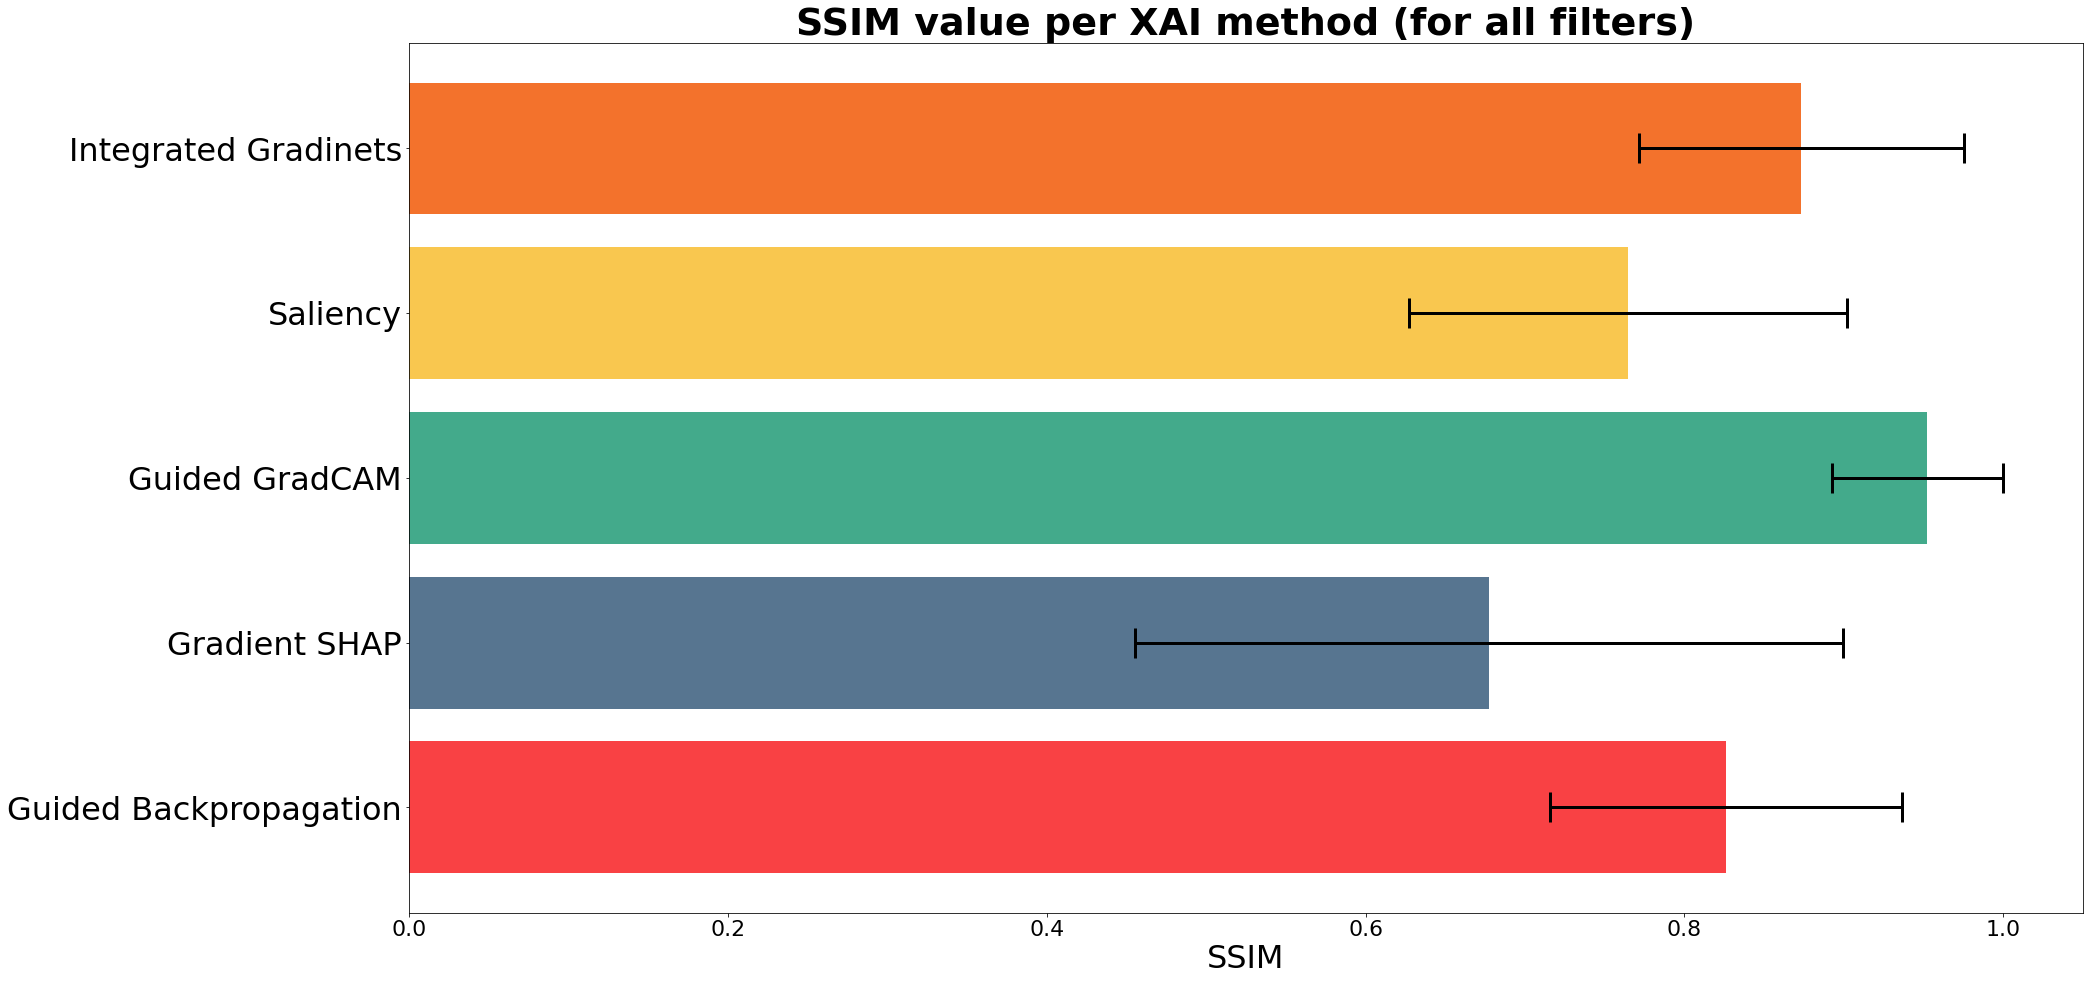

[0.8733429606375033, 0.7644743184875966, 0.9524200010456122, 0.6774220355028008, 0.8260946698692984]
[[0.10201667652849776, 0.10201667652849776], [0.13732856639573301, 0.13732856639573301], [0.059623478031892226, 0.0475799989543878], [0.2220059407368763, 0.2220059407368763], [0.11020755440129518, 0.11020755440129518]]


In [99]:
labels = []
means = []
stds = []

colors = [
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,16)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

aug_type = AUG_TYPES[1]
for method in METHODS.keys():
    means.append(RESULTS[aug_type][method]['mean'])
    stds.append([
        RESULTS[aug_type][method]['std'], 
        min(1.0 - RESULTS[aug_type][method]['mean'], RESULTS[aug_type][method]['std'])
    ])
    labels.append(LABEL_MAP[method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=32)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per XAI method (for all filters)', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/filters-all.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/filters-all.png', bbox_inches='tight')
print(means)
print(stds)
all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + [ '(filters)' + label for label in labels ]

<Figure size 2160x1152 with 0 Axes>

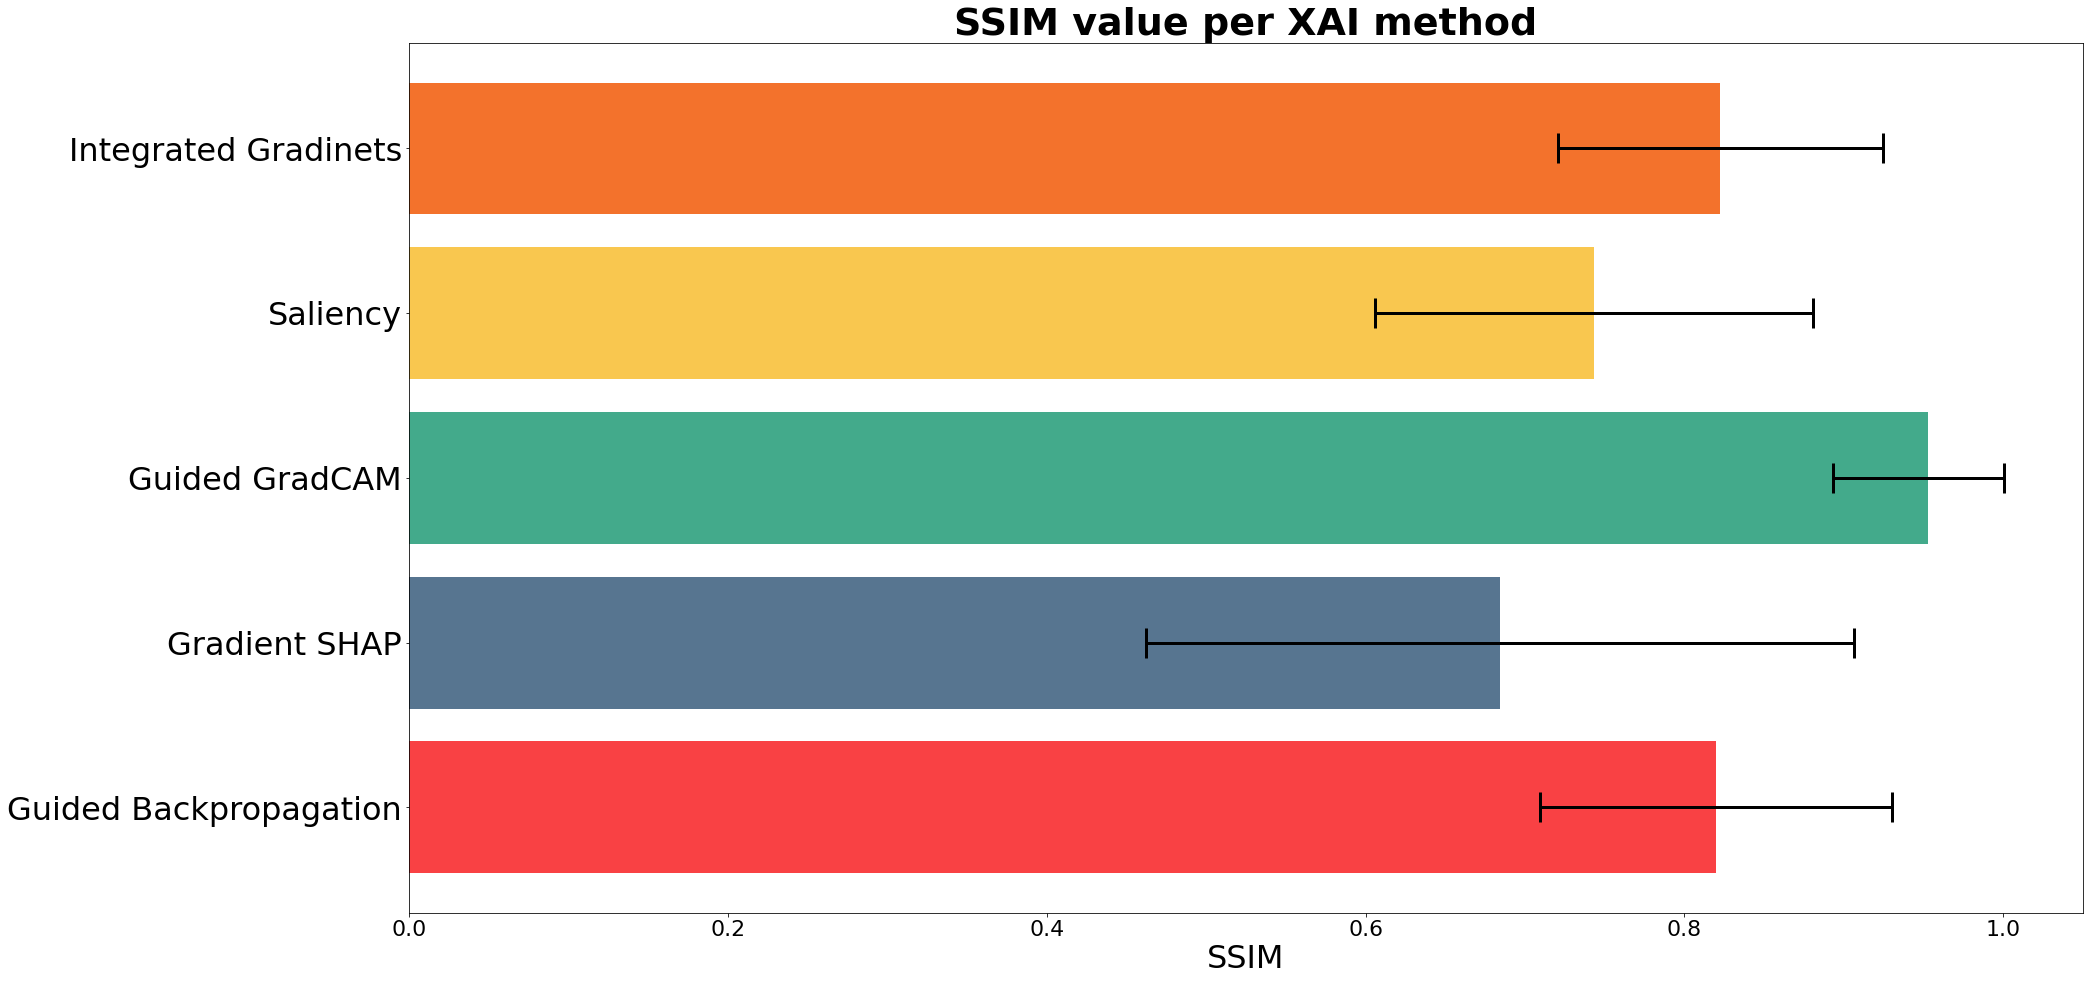

[0.8225348262099557, 0.7431165514079185, 0.9528777869508789, 0.68446498740759, 0.8197755782635124]
[[0.10201667652849776, 0.10201667652849776], [0.13732856639573301, 0.13732856639573301], [0.059623478031892226, 0.0475799989543878], [0.2220059407368763, 0.2220059407368763], [0.11020755440129518, 0.11020755440129518]]


In [100]:
labels = []
means = []
stds = []

colors = [
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,16)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

for method in METHODS.keys():
    means.append(RESULTS[method]['mean'])
    stds.append([
        RESULTS[aug_type][method]['std'], 
        min(1.0 - RESULTS[aug_type][method]['mean'], RESULTS[aug_type][method]['std'])
    ])
    labels.append(LABEL_MAP[method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=32)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per XAI method', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/results-all.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/results-all.png', bbox_inches='tight')
print(means)
print(stds)
all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + labels

In [17]:
all_results = pd.DataFrame(
    {'label': all_labels,
     'mean': all_means,
     'std': all_stds
    }).set_index('label')

In [18]:
all_results

,mean,std
label,,
Integrated Gradinets: -30° rotation,0.725799,0.158716
Saliency: -30° rotation,0.688845,0.155906
Guided GradCAM: -30° rotation,0.950562,0.065098
Gradient SHAP: -30° rotation,0.690652,0.221170
Guided Backpropagation: -30° rotation,0.805060,0.124967
Integrated Gradinets: -15° rotation,0.751758,0.153660
Saliency: -15° rotation,0.723995,0.145409
Guided GradCAM: -15° rotation,0.955176,0.059427
Gradient SHAP: -15° rotation,0.694178,0.215130


In [19]:
print(all_results.to_latex())

\begin{tabular}{lrr}
\toprule
{} &      mean &       std \\
label                                       &           &           \\
\midrule
Integrated Gradinets: -30° rotation         &  0.725799 &  0.158716 \\
Saliency: -30° rotation                     &  0.688845 &  0.155906 \\
Guided GradCAM: -30° rotation               &  0.950562 &  0.065098 \\
Gradient SHAP: -30° rotation                &  0.690652 &  0.221170 \\
Guided Backpropagation: -30° rotation       &  0.805060 &  0.124967 \\
Integrated Gradinets: -15° rotation         &  0.751758 &  0.153660 \\
Saliency: -15° rotation                     &  0.723995 &  0.145409 \\
Guided GradCAM: -15° rotation               &  0.955176 &  0.059427 \\
Gradient SHAP: -15° rotation                &  0.694178 &  0.215130 \\
Guided Backpropagation: -15° rotation       &  0.811523 &  0.124089 \\
Integrated Gradinets: 15° rotation          &  0.751240 &  0.155905 \\
Saliency: 15° rotation                      &  0.732351 &  0.147180 \\
Guided G

In [20]:
## Search for all valid

In [21]:
PER_DATA_RES = { aug_type: { dataset_name: { method_name: {} for method_name in METHODS } for dataset_name in DATASETS.keys() } for aug_type in AUG_TYPES}
for model in MODELS.keys():
    for dataset in DATASETS.keys():
        for data_split in SPLIT_OPTIONS:
            for aug_type in AUG_TYPES:
                for method in METHODS.keys():
                    res_path = os.path.join(base_path, aug_type, dataset, f"{model}-{data_split}", method, f"{model}-{dataset}-{method}-ssim-with-range.csv")
                    method_df = pd.read_csv(res_path, delimiter=';')

                    PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"] = method_df

In [22]:
PER_DATA_RES['rotation']['edible-plants']['ig']['resnet18-100%']

,# 0-ssim,0-score,-30-ssim,-30-score,-15-ssim,-15-score,15-ssim,15-score,30-ssim,30-score
0,1.0,0.999330,0.471439,0.999953,0.499998,0.999973,0.456024,0.999985,0.455416,0.999894
1,1.0,0.964316,0.514156,0.965717,0.546987,0.961093,0.573030,0.754096,0.543886,0.562425
2,1.0,0.970659,0.487858,0.985138,0.500190,0.988226,0.503801,0.996994,0.497305,0.984400
3,1.0,0.504947,0.430360,0.622505,0.452685,0.744478,0.438124,0.917351,0.423080,0.737099
4,1.0,0.998933,0.571632,0.997364,0.606456,0.997635,0.612534,0.997684,0.589842,0.994440
5,1.0,0.983251,0.315620,0.982897,0.350776,0.995609,0.355169,0.985543,0.313916,0.766127
6,1.0,0.999288,0.383872,0.071325,0.398531,0.257620,0.416479,0.838515,0.347861,0.806901
7,1.0,0.833445,0.438786,0.777935,0.430397,0.640702,0.415875,0.737919,0.411443,0.541475
8,1.0,0.676396,0.366268,0.184332,0.404817,0.055517,0.419157,0.177846,0.374042,0.057490
9,1.0,0.992101,0.260899,0.285107,0.273470,0.803089,0.251966,0.975546,0.224392,0.802402


In [23]:
for aug_type in AUG_TYPES:
    for model in MODELS.keys():
        for dataset in DATASETS.keys():
            for data_split in SPLIT_OPTIONS:
                for method in METHODS.keys():
                    for aug_method in KEYS[aug_type][2:]:
                        PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][aug_method[0]] = PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][aug_method[0]][(PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][aug_method[1]] - PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][KEYS[aug_type][1]]).abs() < threshold]

In [103]:
PER_DATA_RES['filters']['stanford-dogs']['gradcam']['efficientnet-100%']

,# none-ssim,none-score,"fx_freaky_details 2,10,1,11,0,32,0-ssim","fx_freaky_details 2,10,1,11,0,32,0-score","normalize_local 8,10-ssim","normalize_local 8,10-score","fx_boost_chroma 90,0,0-ssim","fx_boost_chroma 90,0,0-score","fx_mighty_details 25,1,25,1,11,0-ssim","fx_mighty_details 25,1,25,1,11,0-score",sharpen 300-ssim,sharpen 300-score
0,1.0,0.904867,0.949679,0.904705,0.962799,0.919226,NaN,0.196490,NaN,0.965210,NaN,0.457422
1,1.0,0.940201,0.981803,0.978029,NaN,0.376369,NaN,0.868928,0.981659,0.984677,0.987576,0.969896
2,1.0,0.743010,NaN,0.859904,NaN,0.881080,NaN,0.837790,NaN,0.861067,NaN,0.896204
3,1.0,0.798627,NaN,0.692980,NaN,0.136567,NaN,0.266178,0.881025,0.763544,0.979944,0.797270
4,1.0,0.917821,0.781659,0.911699,0.784715,0.915064,0.761982,0.954660,0.750714,0.951341,0.798645,0.904107
5,1.0,0.519451,NaN,0.263692,NaN,0.432394,NaN,0.444599,NaN,0.138465,NaN,0.585264
6,1.0,0.332155,NaN,0.456109,NaN,0.250844,0.992759,0.307260,NaN,0.534523,NaN,0.388226
7,1.0,0.998916,0.958934,0.999286,0.969036,0.998709,0.948360,0.996580,0.973872,0.999557,0.963087,0.996670
8,1.0,0.886483,NaN,0.700041,NaN,0.682524,0.960995,0.888242,NaN,0.661466,NaN,0.942905
9,1.0,0.949194,0.795920,0.907779,0.816875,0.916063,NaN,0.846573,0.851354,0.922973,0.846268,0.951432


In [47]:
for aug_type in AUG_TYPES:
    for model in MODELS.keys():
        for dataset in DATASETS.keys():
            for data_split in SPLIT_OPTIONS:
                for method in['gradcam']:
                    print(f"{aug_type}][{dataset}][{method}][{model}-{data_split}")
                    print(PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"].dropna())
                    print('-------------------------------------------------')
                    print('-------------------------------------------------')
                    print('-------------------------------------------------')

rotation][edible-plants][gradcam][resnet18-100%
    # 0-ssim   0-score  -30-ssim  -30-score  -15-ssim  -15-score   15-ssim  \
0        1.0  0.999330  0.844422   0.999953  0.825016   0.999973  0.826584   
2        1.0  0.970659  0.955681   0.985138  0.954348   0.988226  0.941211   
4        1.0  0.998933  0.939017   0.997364  0.933314   0.997635  0.912560   
11       1.0  0.997688  0.962596   0.990612  0.965033   0.985065  0.968628   
13       1.0  0.990211  0.768991   0.986805  0.749236   0.991588  0.746444   

    15-score   30-ssim  30-score  
0   0.999985  0.824609  0.999894  
2   0.996994  0.949562  0.984400  
4   0.997684  0.911048  0.994440  
11  0.987329  0.968166  0.997865  
13  0.991982  0.753580  0.987103  
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
rotation][edible-plants][gradcam][resnet18-80%
    # 0-ssim   0-score  -30-ssim  -30-score  -15-ssim  -15-score   15-ssim  

15  0.979699  0.999858    0.9816  
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
rotation][edible-plants][gradcam][densenet-100%
    # 0-ssim   0-score  -30-ssim  -30-score  -15-ssim  -15-score   15-ssim  \
0        1.0  0.988086  0.724983   0.998861  0.746970   0.999634  0.724073   
1        1.0  0.999974  0.871076   0.999753  0.854314   0.999709  0.879646   
4        1.0  0.997826  0.955181   0.996062  0.950650   0.986343  0.936344   
6        1.0  0.999999  0.870633   0.995647  0.861378   0.998795  0.859138   
11       1.0  0.935574  0.939150   0.908662  0.947987   0.938466  0.956200   
13       1.0  0.948658  0.527856   0.942331  0.533521   0.985289  0.502447   

    15-score   30-ssim  30-score  
0   0.999491  0.730059  0.999047  
1   0.999330  0.889073  0.982096  
4   0.994355  0.946475  0.995549  
6   0.998556  0.864481  0.972480  
11  0.950265  0.946886  0.907961  
13  0.9668

-------------------------------------------------
filters][stanford-dogs][gradcam][resnet18-60%
    # none-ssim  none-score  fx_freaky_details 2,10,1,11,0,32,0-ssim  \
16          1.0    0.998452                                 0.910723   

    fx_freaky_details 2,10,1,11,0,32,0-score  normalize_local 8,10-ssim  \
16                                  0.994841                   0.837169   

    normalize_local 8,10-score  fx_boost_chroma 90,0,0-ssim  \
16                    0.997642                     0.902402   

    fx_boost_chroma 90,0,0-score  fx_mighty_details 25,1,25,1,11,0-ssim  \
16                      0.997376                               0.907493   

    fx_mighty_details 25,1,25,1,11,0-score  sharpen 300-ssim  \
16                                0.998528            0.9428   

    sharpen 300-score  
16           0.999161  
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
fil

-------------------------------------------------
-------------------------------------------------
filters][plant-data][gradcam][densenet-80%
    # none-ssim  none-score  fx_freaky_details 2,10,1,11,0,32,0-ssim  \
3           1.0    0.999860                                 0.929163   
5           1.0    0.999980                                 0.954994   
6           1.0    0.999976                                 0.877390   
9           1.0    0.999993                                 0.971621   
10          1.0    0.999929                                 0.908200   
11          1.0    0.993495                                 0.939632   
12          1.0    0.999954                                 0.899941   
13          1.0    0.999903                                 0.936332   
14          1.0    0.988385                                 0.933711   
17          1.0    0.999980                                 0.920228   
18          1.0    0.998409                                 0.935